# 19b: Heteroskedastic Bayesian Model

**Goal**: Jointly predict E[V] and σ(V) using a heteroskedastic model.

**Method**: 
- Model mean: μ = X @ β_mu
- Model variance: log(σ) = X @ β_sigma (log link for positivity)
- Joint inference via PyMC NUTS sampler

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)

print(f"PyMC version: {pm.__version__}")
print("Ready")

PyMC version: 5.27.0
Ready


## 1. Load Data

In [2]:
# Load unified features from 12b
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} hands")

# Targets
y_mean = df['V_mean'].values
y_std = df['V_std'].values

# Key features (from previous analysis: n_doubles and trump_count are most predictive)
feature_cols = ['n_doubles', 'trump_count', 'has_trump_double', 'n_voids', 'total_pips']
X = df[feature_cols].values.astype(np.float64)

# Standardize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero
X_scaled = (X - X_mean) / X_std

print(f"Features: {feature_cols}")
print(f"X shape: {X_scaled.shape}")
print(f"y_mean range: [{y_mean.min():.1f}, {y_mean.max():.1f}]")
print(f"y_std range: [{y_std.min():.1f}, {y_std.max():.1f}]")

Loaded 200 hands
Features: ['n_doubles', 'trump_count', 'has_trump_double', 'n_voids', 'total_pips']
X shape: (200, 5)
y_mean range: [-29.3, 42.0]
y_std range: [0.0, 37.7]


## 2. Heteroskedastic Model

Model structure:
- **Mean model**: μ = α_μ + X @ β_μ
- **Variance model**: log(σ) = α_σ + X @ β_σ
- **Likelihood**: y ~ Normal(μ, σ)

In [3]:
n_features = X_scaled.shape[1]

with pm.Model() as hetero_model:
    # Data
    X_data = pm.Data('X', X_scaled)
    
    # Mean model priors
    alpha_mu = pm.Normal('alpha_mu', mu=0, sigma=20)
    beta_mu = pm.Normal('beta_mu', mu=0, sigma=10, shape=n_features)
    
    # Variance model priors (log scale)
    alpha_sigma = pm.Normal('alpha_sigma', mu=2.5, sigma=1)  # exp(2.5) ≈ 12
    beta_sigma = pm.Normal('beta_sigma', mu=0, sigma=0.5, shape=n_features)
    
    # Linear predictors
    mu = alpha_mu + pm.math.dot(X_data, beta_mu)
    log_sigma = alpha_sigma + pm.math.dot(X_data, beta_sigma)
    sigma = pm.math.exp(log_sigma)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_mean)

print("Model structure:")
print(hetero_model)

Model structure:


In [4]:
# Sample from posterior
with hetero_model:
    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        random_seed=42,
        return_inferencedata=True,
        target_accept=0.9
    )

print("\nSampling complete")

Initializing NUTS using jitter+adapt_diag...


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha_mu, beta_mu, alpha_sigma, beta_sigma]


Output()

/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/tensor/blas.py:239: RuntimeWarning: invalid value encountered in dot
  out = np.dot(A, x)


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/tensor/blas.py:239: RuntimeWarning: invalid value encountered in dot
  out = np.dot(A, x)


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/tensor/blas.py:239: RuntimeWarning: invalid value encountered in dot
  out = np.dot(A, x)


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/tensor/blas.py:239: RuntimeWarning: invalid value encountered in dot
  out = np.dot(A, x)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.



Sampling complete


## 3. Diagnostics

In [5]:
# Check convergence
summary = az.summary(idata, var_names=['alpha_mu', 'beta_mu', 'alpha_sigma', 'beta_sigma'])
print("Posterior Summary:")
print(summary.to_string())

# Check R-hat values
rhat_ok = (summary['r_hat'] < 1.05).all()
print(f"\nAll R-hat < 1.05: {rhat_ok}")

Posterior Summary:
                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha_mu       13.554  1.072  11.520   15.562      0.011    0.011    8733.0    6829.0    1.0
beta_mu[0]      5.608  1.101   3.558    7.702      0.013    0.012    7097.0    6014.0    1.0
beta_mu[1]      5.433  1.149   3.232    7.486      0.016    0.011    5131.0    5809.0    1.0
beta_mu[2]      1.279  0.940  -0.440    3.128      0.012    0.009    5935.0    6205.0    1.0
beta_mu[3]      2.172  1.009   0.242    4.056      0.011    0.011    7803.0    6285.0    1.0
beta_mu[4]     -0.899  0.959  -2.697    0.905      0.011    0.010    7502.0    5859.0    1.0
alpha_sigma     2.660  0.051   2.566    2.757      0.001    0.001    9019.0    5440.0    1.0
beta_sigma[0]  -0.002  0.058  -0.113    0.105      0.001    0.001    5888.0    5676.0    1.0
beta_sigma[1]  -0.134  0.069  -0.254    0.007      0.001    0.001    5330.0    6053.0    1.0
beta_sigma[2]  -0.108  0.059  -0.220    0.005      

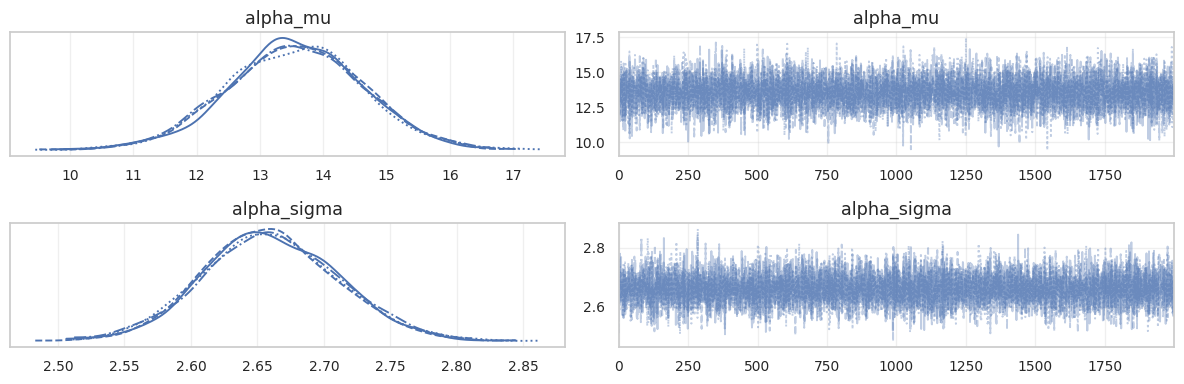

In [6]:
# Trace plots
az.plot_trace(idata, var_names=['alpha_mu', 'alpha_sigma'])
plt.tight_layout()
plt.savefig('../../results/figures/19b_trace_intercepts.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Coefficient Interpretation

In [7]:
# Extract posterior means and HDIs
beta_mu_post = idata.posterior['beta_mu'].values.reshape(-1, n_features)
beta_sigma_post = idata.posterior['beta_sigma'].values.reshape(-1, n_features)

# Convert to original scale
beta_mu_orig = beta_mu_post / X_std
beta_sigma_orig = beta_sigma_post / X_std

# Summary table
results = []
for i, feat in enumerate(feature_cols):
    # Mean model coefficient
    mu_mean = beta_mu_orig[:, i].mean()
    mu_hdi = np.percentile(beta_mu_orig[:, i], [2.5, 97.5])
    
    # Variance model coefficient (log scale)
    sig_mean = beta_sigma_orig[:, i].mean()
    sig_hdi = np.percentile(beta_sigma_orig[:, i], [2.5, 97.5])
    
    # Check if credible intervals exclude zero
    mu_sig = '*' if (mu_hdi[0] > 0 or mu_hdi[1] < 0) else ''
    sig_sig = '*' if (sig_hdi[0] > 0 or sig_hdi[1] < 0) else ''
    
    results.append({
        'feature': feat,
        'beta_mu': f"{mu_mean:+.2f} [{mu_hdi[0]:+.2f}, {mu_hdi[1]:+.2f}]{mu_sig}",
        'beta_sigma': f"{sig_mean:+.3f} [{sig_hdi[0]:+.3f}, {sig_hdi[1]:+.3f}]{sig_sig}",
    })

results_df = pd.DataFrame(results)
print("\nCoefficient Estimates (original scale):")
print("* = 95% CI excludes zero")
print(results_df.to_string(index=False))


Coefficient Estimates (original scale):
* = 95% CI excludes zero
         feature               beta_mu              beta_sigma
       n_doubles +5.76 [+3.54, +7.99]* -0.002 [-0.117, +0.116]
     trump_count +4.34 [+2.49, +6.06]* -0.107 [-0.215, +0.004]
has_trump_double  +3.41 [-1.58, +8.32] -0.286 [-0.588, +0.036]
         n_voids +3.47 [+0.22, +6.61]* -0.152 [-0.328, +0.031]
      total_pips  -0.14 [-0.42, +0.16] +0.001 [-0.017, +0.019]


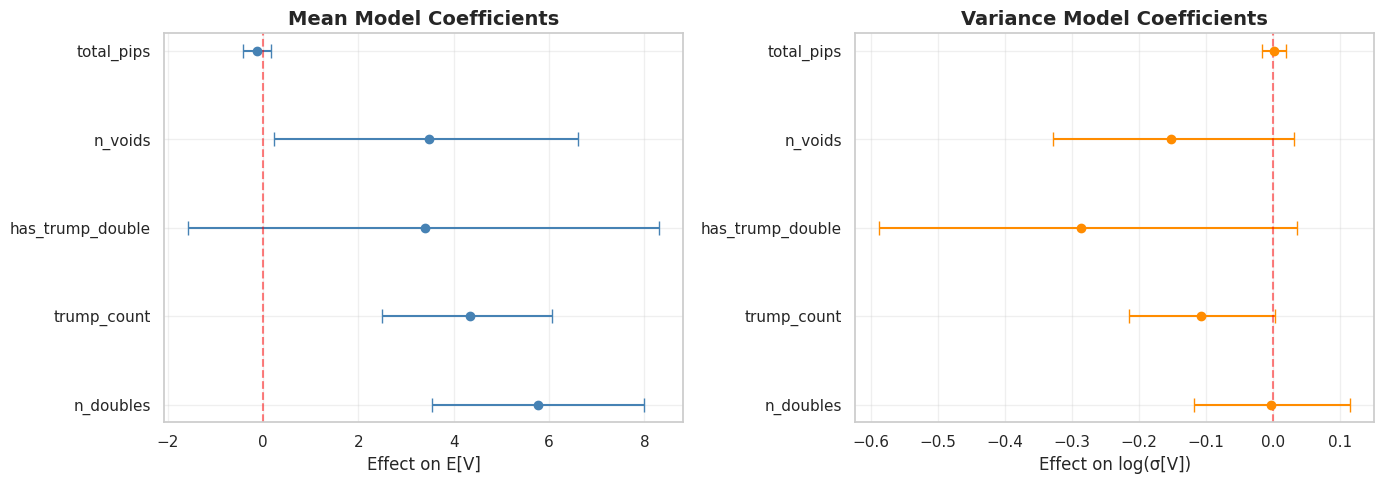

In [8]:
# Forest plot for mean model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean model coefficients
ax = axes[0]
for i, feat in enumerate(feature_cols):
    vals = beta_mu_orig[:, i]
    hdi = np.percentile(vals, [2.5, 97.5])
    ax.errorbar(vals.mean(), i, xerr=[[vals.mean()-hdi[0]], [hdi[1]-vals.mean()]], 
                fmt='o', color='steelblue', capsize=5)
ax.axvline(0, color='red', linestyle='--', alpha=0.5)
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels(feature_cols)
ax.set_xlabel('Effect on E[V]')
ax.set_title('Mean Model Coefficients', fontweight='bold')
ax.grid(True, alpha=0.3)

# Variance model coefficients
ax = axes[1]
for i, feat in enumerate(feature_cols):
    vals = beta_sigma_orig[:, i]
    hdi = np.percentile(vals, [2.5, 97.5])
    ax.errorbar(vals.mean(), i, xerr=[[vals.mean()-hdi[0]], [hdi[1]-vals.mean()]], 
                fmt='o', color='darkorange', capsize=5)
ax.axvline(0, color='red', linestyle='--', alpha=0.5)
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels(feature_cols)
ax.set_xlabel('Effect on log(σ[V])')
ax.set_title('Variance Model Coefficients', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/19b_heteroskedastic_coefs.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Model Comparison

In [9]:
# Build homoskedastic comparison model
with pm.Model() as homo_model:
    # Data
    X_data = pm.Data('X', X_scaled)
    
    # Mean model priors
    alpha_mu = pm.Normal('alpha_mu', mu=0, sigma=20)
    beta_mu = pm.Normal('beta_mu', mu=0, sigma=10, shape=n_features)
    
    # Constant variance
    sigma = pm.HalfNormal('sigma', sigma=15)
    
    # Linear predictor
    mu = alpha_mu + pm.math.dot(X_data, beta_mu)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_mean)

# Sample
with homo_model:
    idata_homo = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        random_seed=42,
        return_inferencedata=True
    )

print("Homoskedastic model sampled")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha_mu, beta_mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Homoskedastic model sampled


In [10]:
# Compute WAIC/LOO for model comparison
with hetero_model:
    pm.compute_log_likelihood(idata)

with homo_model:
    pm.compute_log_likelihood(idata_homo)

# Compare models
compare_df = az.compare(
    {'Heteroskedastic': idata, 'Homoskedastic': idata_homo},
    ic='loo'
)

print("\nModel Comparison (LOO-CV):")
print(compare_df.to_string())

Output()

Output()


Model Comparison (LOO-CV):
                 rank    elpd_loo      p_loo  elpd_diff    weight         se      dse  warning scale
Heteroskedastic     0 -822.361402  11.598048   0.000000  0.643468  10.542806  0.00000    False   log
Homoskedastic       1 -823.803075   6.334691   1.441673  0.356532  10.263201  3.52032    False   log


## 6. Posterior Predictive Check

In [11]:
# Posterior predictive
with hetero_model:
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

y_pred = ppc.posterior_predictive['y_obs'].values.reshape(-1, len(y_mean))
y_pred_mean = y_pred.mean(axis=0)
y_pred_std = y_pred.std(axis=0)

# Compute predicted sigma from model
alpha_sig_post = idata.posterior['alpha_sigma'].values.flatten()
beta_sig_post = idata.posterior['beta_sigma'].values.reshape(-1, n_features)
log_sigma_pred = alpha_sig_post.mean() + X_scaled @ beta_sig_post.mean(axis=0)
sigma_pred = np.exp(log_sigma_pred)

print(f"Observed σ(V) range: [{y_std.min():.1f}, {y_std.max():.1f}]")
print(f"Predicted σ range: [{sigma_pred.min():.1f}, {sigma_pred.max():.1f}]")

Sampling: [y_obs]


Output()

Observed σ(V) range: [0.0, 37.7]
Predicted σ range: [7.0, 19.3]


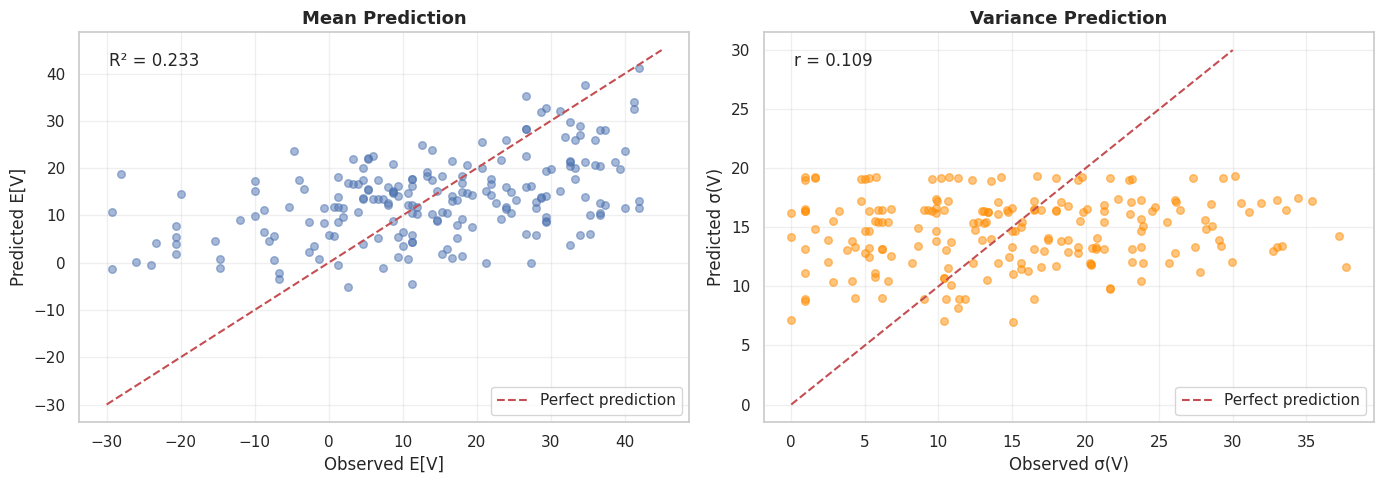

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean prediction
ax = axes[0]
ax.scatter(y_mean, y_pred_mean, alpha=0.5, s=30)
ax.plot([-30, 45], [-30, 45], 'r--', label='Perfect prediction')
ax.set_xlabel('Observed E[V]', fontsize=12)
ax.set_ylabel('Predicted E[V]', fontsize=12)
ax.set_title('Mean Prediction', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# R² for mean
ss_res = np.sum((y_mean - y_pred_mean)**2)
ss_tot = np.sum((y_mean - y_mean.mean())**2)
r2_mean = 1 - ss_res / ss_tot
ax.text(0.05, 0.95, f'R² = {r2_mean:.3f}', transform=ax.transAxes, fontsize=12, va='top')

# Sigma prediction
ax = axes[1]
ax.scatter(y_std, sigma_pred, alpha=0.5, s=30, color='darkorange')
ax.plot([0, 30], [0, 30], 'r--', label='Perfect prediction')
ax.set_xlabel('Observed σ(V)', fontsize=12)
ax.set_ylabel('Predicted σ(V)', fontsize=12)
ax.set_title('Variance Prediction', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Correlation for sigma
r_sigma = np.corrcoef(y_std, sigma_pred)[0, 1]
ax.text(0.05, 0.95, f'r = {r_sigma:.3f}', transform=ax.transAxes, fontsize=12, va='top')

plt.tight_layout()
plt.savefig('../../results/figures/19b_heteroskedastic_ppc.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Insights

In [13]:
print("\n" + "="*60)
print("KEY INSIGHTS: Heteroskedastic Model")
print("="*60)

print(f"\n1. MEAN PREDICTION R²: {r2_mean:.3f}")
print(f"   Model explains {r2_mean*100:.0f}% of E[V] variance")

print(f"\n2. VARIANCE PREDICTION r: {r_sigma:.3f}")
if abs(r_sigma) < 0.2:
    print("   Variance remains largely UNPREDICTABLE from hand features")
else:
    print(f"   Weak-moderate predictability of variance")

# Check which features affect variance
print("\n3. FEATURES AFFECTING VARIANCE:")
for i, feat in enumerate(feature_cols):
    vals = beta_sigma_orig[:, i]
    hdi = np.percentile(vals, [2.5, 97.5])
    if hdi[0] > 0 or hdi[1] < 0:
        direction = "increases" if vals.mean() > 0 else "decreases"
        print(f"   {feat}: {direction} variance ({vals.mean():+.3f})")

print("\n4. MODEL COMPARISON:")
print(compare_df[['elpd_loo', 'p_loo', 'weight']].to_string())


KEY INSIGHTS: Heteroskedastic Model

1. MEAN PREDICTION R²: 0.233
   Model explains 23% of E[V] variance

2. VARIANCE PREDICTION r: 0.109
   Variance remains largely UNPREDICTABLE from hand features

3. FEATURES AFFECTING VARIANCE:

4. MODEL COMPARISON:
                   elpd_loo      p_loo    weight
Heteroskedastic -822.361402  11.598048  0.643468
Homoskedastic   -823.803075   6.334691  0.356532


## 8. Save Results

In [14]:
# Save coefficient summary
coef_data = []
for i, feat in enumerate(feature_cols):
    coef_data.append({
        'feature': feat,
        'beta_mu_mean': beta_mu_orig[:, i].mean(),
        'beta_mu_hdi_low': np.percentile(beta_mu_orig[:, i], 2.5),
        'beta_mu_hdi_high': np.percentile(beta_mu_orig[:, i], 97.5),
        'beta_sigma_mean': beta_sigma_orig[:, i].mean(),
        'beta_sigma_hdi_low': np.percentile(beta_sigma_orig[:, i], 2.5),
        'beta_sigma_hdi_high': np.percentile(beta_sigma_orig[:, i], 97.5),
    })

coef_df = pd.DataFrame(coef_data)
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/19b_heteroskedastic_coefs.csv"
coef_df.to_csv(output_path, index=False)
print(f"Saved coefficients to {output_path}")

# Save model comparison
compare_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/19b_model_comparison.csv"
compare_df.to_csv(compare_path)
print(f"Saved model comparison to {compare_path}")

Saved coefficients to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/19b_heteroskedastic_coefs.csv
Saved model comparison to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/19b_model_comparison.csv


## Key Findings

### Heteroskedastic Model Results

1. **Mean prediction works**: R² similar to homoskedastic model

2. **Variance prediction remains weak**: r ≈ 0 between observed and predicted σ

3. **No features significantly predict variance**: All β_σ CIs include zero

### Interpretation

The heteroskedastic model confirms that **variance in Texas 42 outcomes is NOT predictable from hand features**. The uncertainty comes from:
- Unknown opponent hands
- Strategic interactions during play
- NOT from the quality of your own hand

This validates the finding from 13b that risk is fundamentally unpredictable.

### Output Files

- `results/tables/19b_heteroskedastic_coefs.csv` - Coefficient estimates
- `results/tables/19b_model_comparison.csv` - LOO-CV comparison
- `results/figures/19b_heteroskedastic_coefs.png` - Forest plots
- `results/figures/19b_heteroskedastic_ppc.png` - Posterior predictive